In [ ]:
# ==== CELL 0: Montaje Drive ====
from google.colab import drive
# Si ya está montado, Colab mostrará mensaje. Cambia force_remount=True si quieres forzar.
drive.mount('/content/drive', force_remount=False)

# Ajusta si hace falta:
DATASET_DIR = '/content/drive/MyDrive/p_1_image'  # <-- carpeta que contiene 'benign/' y 'malignant/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==== CELL 1: Instalación dependencias (ejecutar una sola vez) ====
# Nota: instalamos opencv-headless para poder usar cv2 en Colab
!pip install -q tensorflow scikit-image imutils reportlab opencv-python-headless


In [ ]:
# ==== CELL 2: Imports ====
import os, sys, math, random, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from skimage import io as skio, color, filters, feature, measure
from skimage.transform import resize as skresize
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image as kimage
from reportlab.lib.pagesizes import landscape, A4
from reportlab.lib.units import mm
from reportlab.pdfgen import canvas
from reportlab.lib import utils
from reportlab.lib.styles import ParagraphStyle
from reportlab.platypus import Paragraph, Frame
from datetime import datetime
from IPython.display import display
from google.colab import files
import seaborn as sns
import matplotlib

# Ensure TF GPU visibility
print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TF version: 2.19.0
GPU available: []


In [ ]:
# ==== CELL 3: Parámetros globales ====
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
classes = ['benign', 'malignant']


In [ ]:
# ==== CELL 4: Utilidades - load_img, compute_image_features, ensure_img_tensor, draw_image_keep_aspect ====
def load_img(path, target_size=IMAGE_SIZE):
    """Carga una imagen desde disco y la devuelve como uint8 HxWx3 (numpy)"""
    img = skio.imread(path)
    if img is None:
        raise ValueError(f"Imagen {path} no pudo ser leida.")
    if img.ndim == 2:  # grayscale
        img = color.gray2rgb(img)
    img_resized = skresize(img, target_size, anti_aliasing=True)
    img_resized = (img_resized * 255).astype('uint8')
    return img_resized

def compute_image_features(img):
    """
    Extrae 10 features sencillas para EDA (input: uint8 HxWx3)
    - edge_sum: cv2.Canny sumada
    - lbp_var: varianza del histograma LBP
    - contrast: std del gris
    - aspect: h / w
    Devuelve lista de 10 valores en el orden requerido por feat_cols.
    """
    arr = np.array(img)
    if arr.ndim == 2:
        arr = np.stack([arr, arr, arr], axis=-1)
    if arr.ndim != 3:
        raise ValueError(f"Imagen inválida para features: shape {arr.shape}")
    # grayscale float [0,1]
    gray = color.rgb2gray(arr)
    mean_r = float(np.mean(arr[:, :, 0]))
    mean_g = float(np.mean(arr[:, :, 1]))
    mean_b = float(np.mean(arr[:, :, 2]))
    brightness = float(np.mean(gray))
    std_int = float(np.std(gray))
    entropy = float(measure.shannon_entropy((gray * 255).astype('uint8')))
    try:
        img_gray_uint8 = (gray * 255).astype('uint8')
        edges = cv2.Canny(img_gray_uint8, 100, 200)
        edge_sum = float(np.sum(edges))
    except Exception:
        edges_sobel = filters.sobel(gray)
        edge_sum = float(np.sum(edges_sobel))
    try:
        lbp = feature.local_binary_pattern((gray * 255).astype('uint8'), P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 12), density=True)
        lbp_var = float(np.var(lbp_hist))
    except Exception:
        lbp_var = float(np.var((gray * 255).astype('uint8')))
    contrast = float(np.std((gray * 255).astype('float32')))
    h, w = arr.shape[:2]
    aspect = float(h / (w + 1e-9))
    return [mean_r, mean_g, mean_b, brightness, std_int, entropy, edge_sum, lbp_var, contrast, aspect]

def ensure_img_tensor(img):
    """A partir de PIL/np array garantiza un tensor float32 HxWx3"""
    arr = np.array(img)
    if arr.ndim == 2:
        arr = np.stack([arr, arr, arr], axis=-1)
    if arr.ndim == 4:
        arr = arr[0]
    if arr.ndim != 3:
        raise ValueError(f"Imagen inválida: dimensiones {arr.shape}, se esperaba (H,W,3)")
    return tf.convert_to_tensor(arr, dtype=tf.float32)

def draw_image_keep_aspect(c, img_array, x, y, max_width, max_height):
    """
    Dibuja imagen en objeto ReportLab canvas 'c' manteniendo el aspecto.
    img_array: numpy array HxWx3 o ruta
    x, y: coordenada superior izquierda (reportlab origin at bottom-left)
    """
    from PIL import Image
    tmp_path = "/tmp/_tmp_report_image.png"
    img = img_array
    if isinstance(img, np.ndarray):
        if img.ndim == 2:
            img = np.stack([img] * 3, axis=-1)
        pil = Image.fromarray((img).astype('uint8'))
    else:
        pil = Image.open(img)
    pil.save(tmp_path, format='PNG')
    iw, ih = utils.ImageReader(tmp_path).getSize()
    ratio = min(max_width / iw, max_height / ih)
    draw_w = iw * ratio
    draw_h = ih * ratio
    c.drawImage(tmp_path, x, y - draw_h, width=draw_w, height=draw_h, preserveAspectRatio=True, mask='auto')
    try:
        os.remove(tmp_path)
    except:
        pass
    return draw_w, draw_h


In [ ]:
# ==== CELL 5: Cargar paths y DataFrame ====
paths = []
labels = []
for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)
    if not os.path.exists(folder):
        print(f"Atención: carpeta {folder} no existe. Revisa DATASET_DIR y nombres de clases.")
        continue
    files_list = glob(os.path.join(folder, '*'))
    for f in files_list:
        paths.append(f)
        labels.append(cls)

df = pd.DataFrame({'path': paths, 'label': labels})
print("Total imágenes:", len(df))
print(df['label'].value_counts())


Total imágenes: 637
label
malignant    377
benign       260
Name: count, dtype: int64


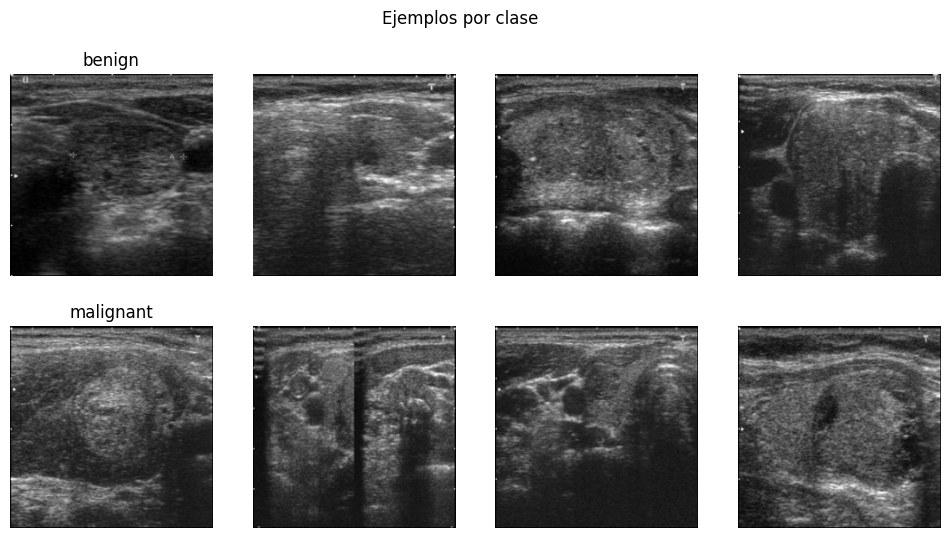

Extrayendo features para EDA: 100%|██████████| 637/637 [00:56<00:00, 11.27it/s]



Estadísticas de features:


,count,mean,std,min,25%,50%,75%,max
mean_r,637.0,6.794915e+01,1.265898e+01,35.400969,5.942492e+01,6.737085e+01,7.599067e+01,1.056911e+02
mean_g,637.0,6.794915e+01,1.265898e+01,35.400969,5.942492e+01,6.737085e+01,7.599067e+01,1.056911e+02
mean_b,637.0,6.794915e+01,1.265898e+01,35.400969,5.942492e+01,6.737085e+01,7.599067e+01,1.056911e+02
brightness,637.0,2.664673e-01,4.964304e-02,0.138827,2.330389e-01,2.641994e-01,2.980026e-01,4.144750e-01
std,637.0,1.455500e-01,1.698793e-02,0.095115,1.333319e-01,1.447544e-01,1.561003e-01,2.169071e-01
entropy,637.0,6.731314e+00,2.034111e-01,5.506553,6.613694e+00,6.753539e+00,6.856921e+00,7.371842e+00
edge_sum,637.0,1.656877e+06,4.120067e+05,468690.000000,1.362210e+06,1.639395e+06,1.914285e+06,3.012315e+06
lbp_var,637.0,2.296142e-03,6.348873e-04,0.001379,1.824648e-03,2.157703e-03,2.664376e-03,5.985335e-03
contrast,637.0,3.711524e+01,4.331921e+00,24.254429,3.399963e+01,3.691236e+01,3.980558e+01,5.531132e+01
aspect,637.0,1.000000e+00,3.999944e-15,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00



Distribución de clases:


,count
label,
malignant,377
benign,260


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


📂 ESTRUCTURA DE DIRECTORIOS:
 • Ruta benigno: /content/drive/MyDrive/p_1_image/benign
 • Ruta maligno: /content/drive/MyDrive/p_1_image/malignant


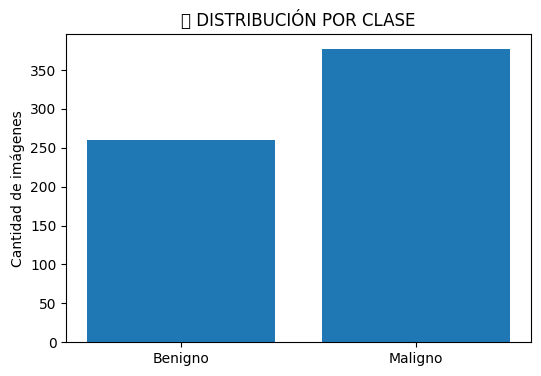

/tmp/ipython-input-1115160510.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ben_contrast, mal_contrast], labels=["Benigno","Maligno"])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


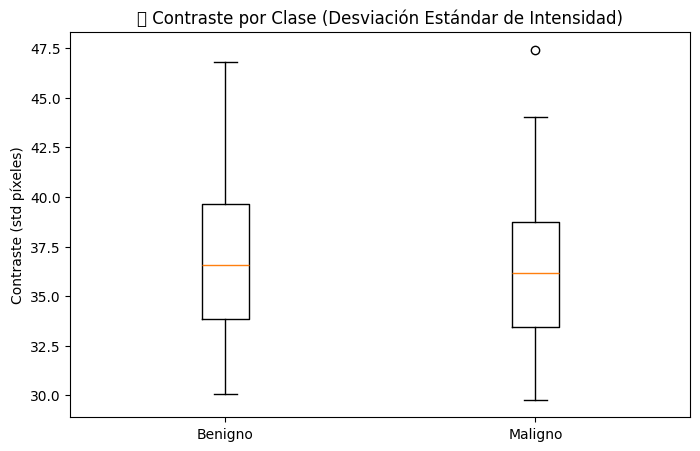

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


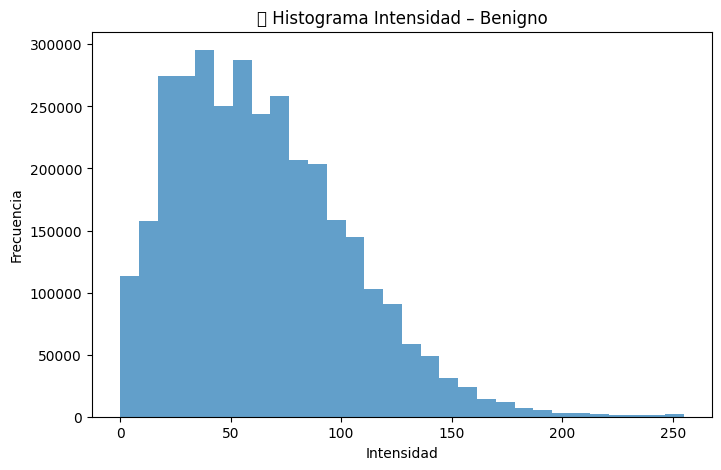

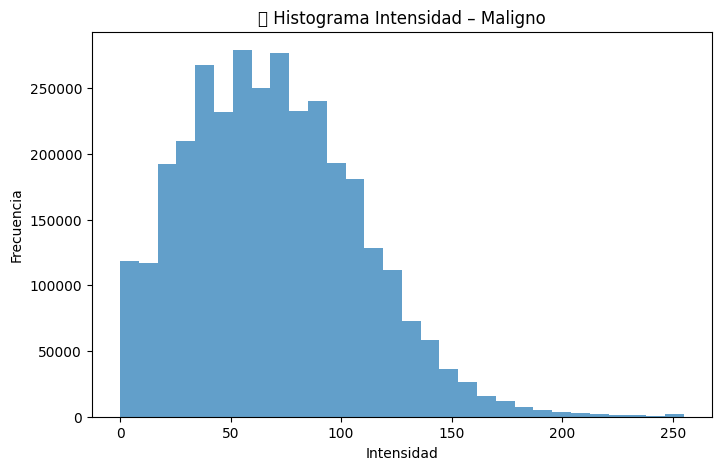

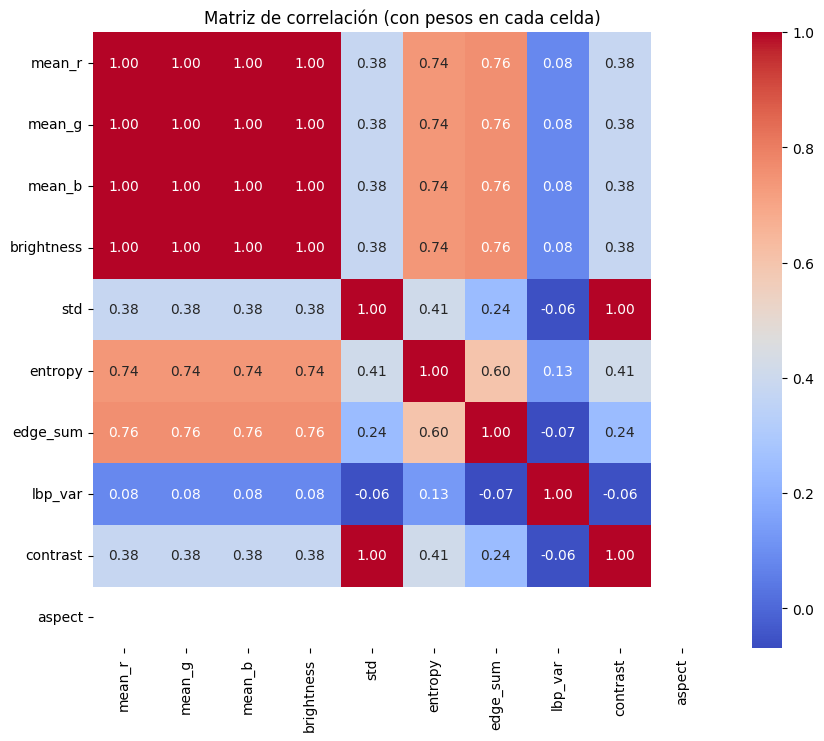

In [ ]:
# ==== CELL 6: EDA completo (llamada automática) ====
# 6.1 - Mostrar ejemplos
def show_examples(df, n_per_class=4):
    plt.figure(figsize=(n_per_class * 3, 6))
    for i, cls in enumerate(classes):
        sample = df[df['label'] == cls].sample(n=min(n_per_class, len(df[df['label'] == cls])), random_state=42).reset_index(drop=True)
        for j, row in sample.iterrows():
            plt.subplot(2, n_per_class, i * n_per_class + j + 1)
            img = load_img(row['path'])
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.title(cls)
    plt.suptitle('Ejemplos por clase')
    plt.show()

# Mostrar ejemplos automáticamente
show_examples(df, n_per_class=4)

# 6.2 - Extraer features para EDA
features_list = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extrayendo features para EDA"):
    try:
        img = load_img(row['path'])
        feats = compute_image_features(img)
    except Exception as e:
        print("Error leyendo", row['path'], e)
        feats = [np.nan] * 10
    features_list.append(feats)

feat_cols = ['mean_r', 'mean_g', 'mean_b', 'brightness', 'std', 'entropy', 'edge_sum', 'lbp_var', 'contrast', 'aspect']
feat_df = pd.DataFrame(features_list, columns=feat_cols)
eda_df = pd.concat([df.reset_index(drop=True), feat_df], axis=1)

# 6.3 - Estadísticas y distribución
print("\nEstadísticas de features:")
display(eda_df[feat_cols].describe().T)

print("\nDistribución de clases:")
display(eda_df['label'].value_counts())

# Rutas
path_benign = "/content/drive/MyDrive/p_1_image/benign"
path_malign = "/content/drive/MyDrive/p_1_image/malignant"

print("📂 ESTRUCTURA DE DIRECTORIOS:")
print(f" • Ruta benigno: {path_benign}")
print(f" • Ruta maligno: {path_malign}")

# Contar imágenes
benign_files = [f for f in os.listdir(path_benign) if f.lower().endswith(('png','jpg','jpeg'))]
malign_files = [f for f in os.listdir(path_malign) if f.lower().endswith(('png','jpg','jpeg'))]

# Distribución por clase
plt.figure(figsize=(6,4))
plt.bar(["Benigno","Maligno"], [len(benign_files), len(malign_files)])
plt.title("📊 DISTRIBUCIÓN POR CLASE")
plt.ylabel("Cantidad de imágenes")
plt.show()

# ===============================================
# 📌 NUEVO: ANÁLISIS DE CONTRASTE POR CLASE
# ===============================================

def calcular_contraste(path, files, n=50):
    valores = []
    for img_name in files[:n]:
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            valores.append(img.std())
    return valores

ben_contrast = calcular_contraste(path_benign, benign_files)
mal_contrast = calcular_contraste(path_malign, malign_files)

plt.figure(figsize=(8,5))
plt.boxplot([ben_contrast, mal_contrast], labels=["Benigno","Maligno"])
plt.title("📈 Contraste por Clase (Desviación Estándar de Intensidad)")
plt.ylabel("Contraste (std píxeles)")
plt.show()

# ===============================================
# 📌 NUEVO: HISTOGRAMAS DE INTENSIDAD POR CLASE
# ===============================================

def plot_histograms(image_paths, title):
    plt.figure(figsize=(8,5))
    all_pixels = []
    for img_name in image_paths[:50]:
        img = cv2.imread(os.path.join(path_benign if "Benigno" in title else path_malign, img_name),
                         cv2.IMREAD_GRAYSCALE)
        if img is not None:
            all_pixels.extend(img.flatten())

    plt.hist(all_pixels, bins=30, alpha=0.7)
    plt.title(title)
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    plt.show()

plot_histograms(benign_files, "📊 Histograma Intensidad – Benigno")
plot_histograms(malign_files, "📊 Histograma Intensidad – Maligno")

# 6.4 - Matriz de correlación con pesos en cada cuadro (annotated heatmap)
corr = eda_df[feat_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=feat_cols, yticklabels=feat_cols)
plt.title('Matriz de correlación (con pesos en cada celda)')
plt.show()


In [ ]:
# ==== CELL 7: Preparar datasets con ImageDataPipeline ====
# Usamos image_dataset_from_directory para rapidez y facilidad (mantener etiquetas)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Mostrar balance en train
labels_list = []
for x, y in train_ds.unbatch().as_numpy_iterator():
    labels_list.append(np.argmax(y))
counts = np.bincount(labels_list)
print("Conteo train (benign, malignant):", counts)

# Calcular class weights
try:
    y_vals = np.array(labels_list)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_vals), y=y_vals)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
except Exception:
    class_weight_dict = {0: 1.0, 1: 1.0}
print("Class weights:", class_weight_dict)


Found 637 files belonging to 2 classes.
Using 510 files for training.
Found 637 files belonging to 2 classes.
Using 127 files for validation.
Conteo train (benign, malignant): [205 305]
Class weights: {0: np.float64(1.2439024390243902), 1: np.float64(0.8360655737704918)}
